<a href="https://colab.research.google.com/github/gtbook/robotics/blob/main/S33_vacuum_sensing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
%pip install -U -q gtbook

Note: you may need to restart the kernel to use updated packages.


In [9]:
import numpy as np
import gtsam

import gtbook
import gtbook.display
from gtbook import vacuum
from gtbook.discrete import Variables
VARIABLES = Variables()
def pretty(obj): 
    return gtbook.display.pretty(obj, VARIABLES)
def show(obj, **kwargs): 
    return gtbook.display.show(obj, VARIABLES, **kwargs)

In [10]:
# From section 3.2:
wxyz = gtsam.DiscreteBayesNet()
W1 = VARIABLES.binary("W")
X1 = VARIABLES.binary("X")
Y1 = VARIABLES.binary("Y")
Z1 = VARIABLES.binary("Z")
wxyz.add(W1, [X1, Z1], "1/1 1/1 1/1 1/1")
wxyz.add(X1, [Y1, Z1], "1/1 1/1 1/1 1/1")
wxyz.add(Y1, [Z1], "1/1 1/1")
wxyz.add(Z1, "1/1")

N = 5
X = VARIABLES.discrete_series("X", range(1, N+1), vacuum.rooms)
A = VARIABLES.discrete_series("A", range(1, N), vacuum.action_space)

# Dynamic Bayes Nets

> Dynamic Bayes nets replicate a Bayes net fragment over time.

**This Section is still in draft mode and was released for adventurous spirits (and TAs) only.**

The Markov chain we discussed in the previous section is an example of a **Dynamic Bayes Net** or **DBN**: a Bayes net in which  *Bayes net slices* are replicated through time, to model the evolution of states over time. Below we add observations into the mix, and show how we can simulate the complete system using a technique called *ancestral sampling*.

## A Sensor Model

First, we need to see a few things about sensing for our example system. This chapter is primarily focused on action, and hence the sensing we will consider is fairly simple. Let us conceive of a simple light sensor that gives an indication as to which room we are in. Specifically, let us assume that the living room and kitchen are on the south side, and hence have a lot of light on a typical day. The office in the dining room or on the north side, and the light sensor will typically respond with medium light levels. The hallway, on the other hand, is very dark as it has few windows. The following conditional probability distribution captures  these semantics:

In [11]:
# vacuum.light_levels = ["dark", "medium", "light"]
Z = VARIABLES.discrete_series("Z", range(1, N+1), vacuum.light_levels)
# vacuum.sensor_spec = "1/1/8 1/1/8 2/7/1 8/1/1 1/8/1"
pretty(gtsam.DiscreteConditional(Z[1], [X[1]], vacuum.sensor_spec))

X1,dark,medium,light
Living Room,0.1,0.1,0.8
Kitchen,0.1,0.1,0.8
Office,0.2,0.7,0.1
Hallway,0.8,0.1,0.1
Dining Room,0.1,0.8,0.1


Single time step reasoning will fall short for our vacuuming robot, which operates in time. for example, recall from the previous chapter that given a sensor reading of, say, `medium`, the maximum likelihood estimate (MLE) for the location of the robot is `dining room`: it corresponds to the highest value in the `medium` column. 
Intuitively, however, we should be able to use our history to obtain a better estimate of the location of the robot. For example, if you were just in the living room, there is no way that we could have gotten to the dining room in a single step. In this section we will see how we can reason probabilistically about such things.

## Dynamic Bayes Nets

Note that directed cycles are not allowed in a Bayes net, i.e., the
graph is acyclic. Hence, one might wonder how we deal with time: if a
robot is all about the sense-think-act cycle, would we not expect a
cycle in the graph when describing robots? The answer is to unroll time,
as we show below.

When a Bayes net is used to represent the evolution of a system or agent
over time, we call it a **dynamic Bayes net** or DBN. 

The following piece of code builds the entire vacuuming robot dynamic Bayes net. Note we take care to add variables *before* we add any of there parents (hence the `reversed` below) for reasons that will soon become clear:

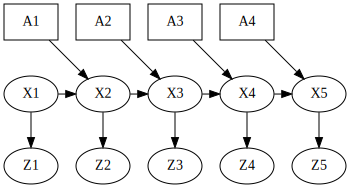

In [12]:
dbn = gtsam.DiscreteBayesNet()
for k in range(1,N+1):
    dbn.add(Z[k], [X[k]], vacuum.sensor_spec)
for k in reversed(range(1, N)):
    dbn.add(X[k+1], [X[k], A[k]], vacuum.action_spec)
dbn.add(X[1], "1/1/1/1/1")
show(dbn, hints={"A":2, "X":1, "Z":0}, boxes={A[k][0] for k in range(1,N)})

You can see that after the first time step, the Bayes net is simply repeating the "AXZ" pattern (or *slice*!) over and over again. The joint distribution over states $X$ and measurements $Z$, *given* the action sequence $A$ is given

$$P(Z,X|A)= P(Z_1| X_1) P(X_1) \prod_{k=2}^{N} P(Z_k| X_k) P(X_k|A_k,X_{k-1}) $$ 

## Ancestral Sampling

Recall the more example Bayes net example on the 4 variables W,X,Y,Z, with joint distribution 

$$P(W,X,Y,Z)=P(W|X,Y)P(X|Y,Z)P(Y|Z)P(Z):$$ 

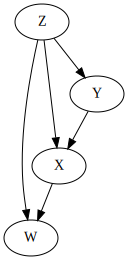

In [13]:
show(wxyz)

Sampling from the joint distribution given in Bayes net form can be done
by sampling each variable in turn, but making sure that we always sample
a node’s parents first. This can be done through the notion of a
**topological sort** of the DAG.

An easy algorithm to obtain a topological sort is **Kahn’s algorithm**,
which recursively removes a node from the graph that either has no
parents, or whose parents have all been removed already. The order in
which nodes were removed constitutes a (non-unique) topological sort
order.

Sampling is then done by inverse transform sampling for each variable
separately, in topological sort order. The graph above happens to be laid out already in topological sort order, if read from top to bottom.
Hence, in this example we sample first $Z$, then $Y$, then $X$, and then
$W$. Note that in this case the topological sort is unique, but that is
an exception rather than the rule.

## Simulation of a Robot

Simulation of a robot is then equivalent
to ancestral sampling from this DBN, and in this case the topological sort is
rather obvious. Hence, so is the simulation algorithm, to sample from $P(X,Z|A)$:

1.  First, assign $k\leftarrow1$, and sample the initial state $x_1$ from $P(X_1)$, a prior
    over the state. We write

$$x_1 \sim P(X_1)$$

2.  Next, simulate the sensor reading by sampling from the sensor model
    
$$o_{k} \sim P(O_{k}|X_{k}=x_{k})$$

3.  Lastly, simulate the effect of the (given) action $a_k$ by sampling the next
    state $x_{k+1}$:

$$x_{k+1} \sim P(X_{k+1}|X_{k}=s_{k},A_{k}=a_{k}).$$

4.  Increase $k\leftarrow k+1$ and return to step $2$.

Note that this algorithm is generic for all robot models with this action/sensing structure.

### Exercise

Simulate two different realizations from the dynamic Bayes net above.

## Ancestral Sampling with GTSAM
Of course, GTSAM has a method built in to do ancestral sampling, *but* it only works for a *reverse* topologically sorted Bayes nets. This matches the way we write down joint distributions, with parents towards the right, and it is also why above we used the built-in `reversed` on the range: this was to make sure that later states get sampled last. Because we only specified $P(Z,X|A)$, we need to give an action sequence as argument:

In [14]:
actions = VARIABLES.assignment({A[k]: "R" for k in range(1,N)})
pretty(dbn.sample(actions))

Variable,value
A1,R
A2,R
A3,R
A4,R
X1,Living Room
X2,Kitchen
X3,Kitchen
X4,Kitchen
X5,Kitchen
Z1,light


The actions are included in the resulting `DiscreteValues` instance, so we have a complete picture of one sampled "world state".

## GTSAM 101
> The GTSAM concepts used in this section, explained.

We use the `gtsam.DiscreteBayesNet` method `sample`, with signature

```python
    sample(self, given: gtsam::DiscreteValues) -> gtsam::DiscreteValues
```

It implements ancestral sampling, but assumes the Bayes net is reverse topologically sorted, i.e. last
conditional will be sampled first. In addition, it can optionally take an assignment for certain *given* variables.
In that case, it is also assumed that the Bayes net does not contain any conditionals for the given values.
We used this functionality to pass the given action sequence above.